<a href="https://colab.research.google.com/github/eric1645/CSE--/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.코드**

In [ ]:
pip install numba

In [24]:
from numba import njit

@njit
def pressure_poisson(p, rhs, h, tol=1e-6, max_iter=10000, omega=1.9):

    n = rhs.shape[0]
    for it in range(max_iter):
        # 내부 격자 업데이트
        for i in range(1, n+1):
            for j in range(1, n+1):
                p[i,j] = (1-omega)*p[i,j] + omega*0.25*(
                    p[i+1,j] + p[i-1,j] + p[i,j+1] + p[i,j-1]
                    - h**2 * rhs[i-1,j-1]
                )

        # Neumann 경계조건
        p[0,:]  = p[1,:]      # 아래쪽
        p[-1,:] = p[-2,:]     # 위쪽
        p[:,0]  = p[:,1]      # 왼쪽
        p[:,-1] = p[:,-2]     # 오른쪽

        # 기준점 압력 고정 (예: 좌하단 모서리)
        p[0,0] = 0.0

        # ✅ 잔차 계산 (L∞ norm)
        residual = 0.0

        # Jacobi/SOR 업데이트를 벡터화

        for i in range(1, n+1):
            for j in range(1, n+1):
                r_ij = ( (p[i+1,j] + p[i-1,j] + p[i,j+1] + p[i,j-1] - 4*p[i,j]) / h**2
                         - rhs[i-1,j-1] )
                residual = max(residual, abs(r_ij))

        if residual < tol:

            break

    return p


In [ ]:
import numpy as np
from scipy.sparse import diags, kron, identity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from google.colab import drive
from numba import njit

drive.mount('/content/drive')

# 저장 경로 지정 (예: MyDrive/cavity_flow.npz)
save_path = "/content/drive/MyDrive/cavity_flow_400_128.npz"

np.set_printoptions(precision=3, suppress=True)

def u_convection_term(u, v, h):
  u_left = (u[1:-1,:-2] + u[1:-1,1:-1])/2
  u_right = (u[1:-1,1:-1] + u[1:-1,2:])/2
  uv_up = ((u[1:-1,1:-1] + u[2:,1:-1])/2)*((v[1:,1:-2] + v[1:,2:-1])/2)
  uv_down = ((u[:-2,1:-1] + u[1:-1,1:-1])/2)*((v[:-1,1:-2] + v[:-1,2:-1])/2)

  Hu = (u_right**2 - u_left**2)/h + (uv_up - uv_down)/h
  #u[1:-1,1:-1] = Hu

  return Hu #내부 격자

def v_convection_term(u, v, h):
  v_up = (v[1:-1,1:-1] + v[2:,1:-1])/2
  v_down = (v[:-2,1:-1] + v[1:-1,1:-1])/2
  vu_right = ((v[1:-1,1:-1] + v[1:-1,2:])/2)*((u[1:-2,1:] + u[2:-1,1:])/2)
  vu_left = ((v[1:-1,:-2] + v[1:-1,1:-1])/2)*((u[1:-2,:-1] + u[2:-1,:-1])/2)

  Hv = (v_up**2 - v_down**2)/h + (vu_right - vu_left)/h
  #v[1:-1,1:-1] = Hv

  return Hv #내부 격자

#TDMA(a: 하부대각, b: 주대각, c: 상부대각, d: 우변)
def TDMA(a, b, c, d):

    n = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    xc = np.zeros_like(dc)

    # Forward elimination
    for i in range(1, n):
        mc = ac[i-1] / bc[i-1]
        bc[i] -= mc * cc[i-1]
        dc[i] -= mc * dc[i-1]

    # Back substitution
    xc[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        xc[i] = (dc[i] - cc[i] * xc[i+1]) / bc[i]

    return xc


def u_TDMA(u, v, n, b, beta):
    a_x = -beta * np.ones(n-2)  # 하부대각
    b_x = (1 + 2*beta) * np.ones(n-1)  # 주대각
    c_x = -beta * np.ones(n-2)  # 상부대각

    a_y = -beta * np.ones(n-1)
    b_y = (1 + 2*beta) * np.ones(n)
    c_y = -beta * np.ones(n-1)
    b_y[0] = b_y[-1] =  1 + 3*beta  # ghost cell 반영
    #b_y[-1] = 1 + (3-2*U)*beta

    phi = np.zeros((n, n-1))
    delta_u = np.zeros((n, n-1))

    # 1단계: x방향 TDMA
    for i in range(n):
        rhs = b[i,:]  # 행 i
        phi[i, :] = TDMA(a_x, b_x.copy(), c_x, rhs)

    # 2단계: y방향 TDMA
    for j in range(n-1):
        rhs = phi[:, j]
        rhs[-1] += 2*beta*U
        delta_u[:, j] = TDMA(a_y, b_y.copy(), c_y, rhs)

    return delta_u #4x5

def v_TDMA(u, v, n, b, beta):
    a_y = -beta * np.ones(n-2)  # 하부대각
    b_y = (1 + 2*beta) * np.ones(n-1)  # 주대각
    c_y = -beta * np.ones(n-2)  # 상부대각

    a_x = -beta * np.ones(n-1)
    b_x = (1 + 2*beta) * np.ones(n)
    c_x = -beta * np.ones(n-1)
    b_x[0] = b_x[-1] = 1 + 3*beta  # ghost cell 반영

    phi = np.zeros((n-1, n))
    delta_v = np.zeros((n-1, n))

    # 1단계: y방향 TDMA
    for i in range(n):
        rhs = b[:, i]  # 열 방향
        phi[:, i] = TDMA(a_y, b_y.copy(), c_y, rhs)

    # 2단계: x방향 TDMA
    for j in range(n-1):
        rhs = phi[j, :]
        delta_v[j, :] = TDMA(a_x, b_x.copy(), c_x, rhs)

    return delta_v #5x4

def cal_b(u_new, u, v_new, v, dt, beta, h):
  u_b = u_new[:-2,1:-1] + u_new[2:,1:-1] + u_new[1:-1,2:] + u_new[1:-1,:-2] -4*u_new[1:-1,1:-1]
  v_b = v_new[:-2,1:-1] + v_new[2:,1:-1] + v_new[1:-1,2:] + v_new[1:-1,:-2] -4*v_new[1:-1,1:-1]

  Hu = -dt*(3*u_convection_term(u_new, v_new, h)-u_convection_term(u, v, h))/2
  Hv = -dt*(3*v_convection_term(u_new, v_new, h)-v_convection_term(u, v, h))/2

  return Hu + 2*beta*u_b, Hv + 2*beta*v_b

def cal_intermediate_u(u_new, u, v_new, v, dt, beta, h, n):

  b_u, b_v = cal_b(u_new, u, v_new, v, dt, beta, h)
  delta_u = u_TDMA(u_new, v_new, n, b_u, beta)

  return delta_u + u_new[1:-1,1:-1]

def cal_intermediate_v(u_new, u, v_new, v, dt, beta, h, n):

  b_u, b_v = cal_b(u_new, u, v_new, v, dt, beta, h)
  delta_v = v_TDMA(u_new, v_new, n, b_v, beta)

  return delta_v + v_new[1:-1,1:-1]

def cal_div(u, v, h):
  u_right = u[1:-1,1:]
  u_left = u[1:-1,:-1]
  v_up = v[1:,1:-1]
  v_down = v[:-1,1:-1]

  return (u_right - u_left + v_up - v_down)/h

#Parameters
H = 1
U = 1
Re = 400
nu = U * H / Re
dt = 0.001

#격자 설정
n = 128
h = H / n
x = np.linspace(0, H, n+1)
y = np.linspace(0, H, n+1)
X, Y = np.meshgrid(x, y)

#beta 설정
beta = dt/(2*Re*(h**2))

#압력, 속도 초기값(t0, t1)
p = np.zeros((n+2, n+2))
u = np.zeros((n+2, n+1))
u_new = np.zeros((n+2, n+1))
u_new[-1,:] = 2*U
v= np.zeros((n+1, n+2))
v_new = np.zeros((n+1, n+2))

tol = 1e-6  # 수렴 기준
max_iter = 30000  # 최대 반복 제한

for it in range(max_iter):
    # use explicit copies for star-steps
    u_star = u_new.copy()
    v_star = v_new.copy()

    # use previous and current time-levels for AB2
    u_star[1:-1,1:-1] = cal_intermediate_u(u_new, u, v_new, v, dt, beta, h, n)
    v_star[1:-1,1:-1] = cal_intermediate_v(u_new, u, v_new, v, dt, beta, h, n)

    u = u_new.copy()
    v = v_new.copy()

    # boundary conditions on star (same as before)
    u_star[0,:] = -u_star[1,:]
    u_star[-1,:] = 2*U - u_star[-2,:]
    v_star[:,0] = -v_star[:,1]
    v_star[:,-1] = -v_star[:,-2]
    u_star[1:-1,0] = u_star[1:-1,-1] = 0
    v_star[0, 1:-1] = v_star[-1, 1:-1] = 0

    '''
    # solve pressure
    poisson_rhs = cal_div(u_star, v_star, h)/dt
    p = pressure_poisson(p, poisson_rhs, h)
    '''
    # solve pressure
    poisson_rhs = cal_div(u_star, v_star, h)/dt

    # ✅ Neumann 호환성(compatibility) 강제: 평균 0
    poisson_rhs -= poisson_rhs.mean()
    p = pressure_poisson(p, poisson_rhs, h)

    p_on_x = (p[1:-1,2:-1] - p[1:-1,1:-2])/h
    p_on_y = (p[2:-1,1:-1] - p[1:-2,1:-1])/h

    # projection
    u_new[1:-1,1:-1] = u_star[1:-1,1:-1] - dt*p_on_x
    v_new[1:-1,1:-1] = v_star[1:-1,1:-1] - dt*p_on_y

    # ghost & BC reset (as you had)
    u_new[0,:] = -u_new[1,:]
    u_new[-1,:] = 2*U - u_new[-2,:]
    v_new[:,0] = -v_new[:,1]
    v_new[:,-1] = -v_new[:,-2]
    u_new[1:-1,0] = u_new[1:-1,-1] = 0
    v_new[0, 1:-1] = v_new[-1, 1:-1] = 0

    # ✅ 정상상태 체크
    diff_u = np.max(np.abs(u_new - u))
    diff_v = np.max(np.abs(v_new - v))
    residual = max(diff_u, diff_v)

    if it % 100 == 0:
        print(f"iter {it}, residual = {residual:.2e}")

    if residual < tol:
        print(f"정상상태 도달! iter = {it}, residual = {residual:.2e}")
        break

np.savez(save_path, u=u_new, v=v_new, p=p, X=X, Y=Y)
print("저장 완료:", save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
iter 0, residual = 1.14e-01
iter 100, residual = 4.00e-03
iter 200, residual = 2.33e-03
iter 300, residual = 1.87e-03
iter 400, residual = 1.59e-03
iter 500, residual = 1.39e-03
iter 600, residual = 1.23e-03
iter 700, residual = 1.09e-03
iter 800, residual = 9.74e-04
iter 900, residual = 8.76e-04
iter 1000, residual = 7.91e-04
iter 1100, residual = 7.31e-04
iter 1200, residual = 6.94e-04
iter 1300, residual = 6.58e-04
iter 1400, residual = 6.24e-04
iter 1500, residual = 5.95e-04
iter 1600, residual = 5.66e-04
iter 1700, residual = 5.40e-04
iter 1800, residual = 5.14e-04
iter 1900, residual = 4.90e-04
iter 2000, residual = 4.67e-04
iter 2100, residual = 4.46e-04
iter 2200, residual = 4.26e-04
iter 2300, residual = 4.06e-04
iter 2400, residual = 3.88e-04
iter 2500, residual = 3.70e-04
iter 2600, residual = 3.54e-04
iter 2700, residual = 3.38e-04
iter 2800, resi

In [3]:
data = np.load("/content/drive/MyDrive/cavity_flow_1000_128.npz")
u, v, p = data["u"], data["v"], data["p"]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/cavity_flow_1000_128.npz'

#**2. Steady State**

##논문 데이터

In [27]:
import numpy as np

# y 좌표
y_vals = np.array([
    1.0000, 0.9766, 0.9688, 0.9609, 0.9531,
    0.8516, 0.7344, 0.6172, 0.5000, 0.4531,
    0.2813, 0.1719, 0.1016, 0.0703, 0.0625,
    0.0547, 0.0000
])

# 각 Reynolds 수에 따른 u 값
u_data = {
    100: np.array([1.0000, 0.84123, 0.78871, 0.73722, 0.68717,
                   0.23151, 0.00332, -0.13641, -0.20581, -0.21090,
                   -0.15662, -0.10150, -0.06434, -0.04775, -0.04192,
                   -0.03717, 0.00000]),

    400: np.array([1.0000, 0.75837, 0.68439, 0.61756, 0.55892,
                   0.29093, 0.16256, 0.02135, -0.11477, -0.17119,
                   -0.32726, -0.24299, -0.14612, -0.10338, -0.09266,
                   -0.08186, 0.00000]),

    1000: np.array([1.0000, 0.65928, 0.57492, 0.51117, 0.46604,
                    0.33304, 0.18719, 0.05702, -0.06080, -0.10648,
                    -0.27805, -0.38289, -0.29730, -0.22220, -0.19660,
                    -0.18109, 0.00000])
}

# x 좌표
x_vals = np.array([
    1.0000, 0.9688, 0.9609, 0.9531, 0.9453,
    0.9063, 0.8594, 0.8047, 0.5000, 0.2344,
    0.2266, 0.1563, 0.0938, 0.0781, 0.0703,
    0.0625, 0.0000
])

# 각 Reynolds 수에 따른 v 값
v_data = {
    100: np.array([0.00000, -0.05906, -0.07391, -0.08864, -0.10313,
                   -0.16914, -0.22445, -0.24533, 0.05454, 0.17527,
                   0.17507, 0.16077, 0.12317, 0.10890, 0.10091,
                   0.09233, 0.00000]),

    400: np.array([0.00000, -0.12146, -0.15663, -0.19254, -0.22847,
                   -0.23827, -0.44993, -0.38598, 0.05186, 0.30174,
                   0.30203, 0.28124, 0.22965, 0.20920, 0.19713,
                   0.18360, 0.00000]),

    1000: np.array([0.00000, -0.21388, -0.27669, -0.33714, -0.39188,
                    -0.51550, -0.42665, -0.31966, 0.02526, 0.32235,
                    0.33075, 0.37095, 0.32627, 0.30353, 0.29012,
                    0.27485, 0.00000]),
}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


##(1) Re = 100

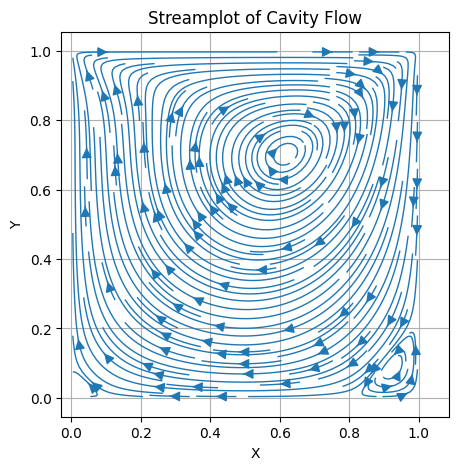

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 데이터 불러오기
data = np.load("/content/drive/MyDrive/cavity_flow_100_128.npz")
u = data['u']  # (n+2, n+1)
v = data['v']  # (n+1, n+2)
X = data['X']  # (n+1, n+1)
Y = data['Y']  # (n+1, n+1)

u_center = (u[1:-1, :-1] + u[1:-1, 1:]) / 2  # 크기: (n, n)
v_center = (v[:-1, 1:-1] + v[1:, 1:-1]) / 2  # 크기: (n, n)

X_center = (X[:-1, :-1] + X[1:, 1:]) / 2
Y_center = (Y[:-1, :-1] + Y[1:, 1:]) / 2

# Streamplot 그리기
plt.figure(figsize=(5, 5))
plt.streamplot(X_center, Y_center, u_center, v_center, density=2, linewidth=1, arrowsize=1.5)
plt.title('Streamplot of Cavity Flow')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()


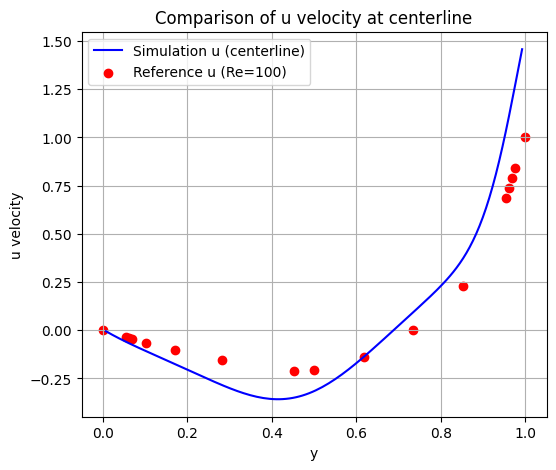

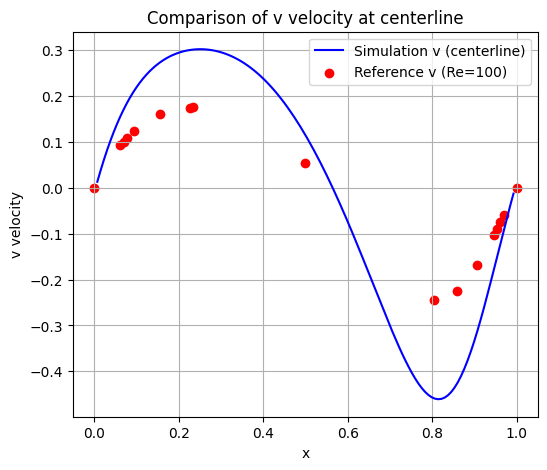

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 시뮬레이션 데이터 불러오기
data = np.load("/content/drive/MyDrive/cavity_flow_100_128.npz")
u, v, p = data["u"], data["v"], data["p"]

# 중심선 좌표 (128개, 내부 격자점)
centerline = np.linspace(1/129, 128/129, 128)

# 시뮬레이션 중심선 데이터
u_centerline = u[1:-1, 64]  # shape (128,)
v_centerline = v[64, 1:-1]  # shape (128,)

# u 비교 그래프 (y 축 방향)
plt.figure(figsize=(6,5))
plt.plot(centerline, u_centerline, 'b-', label='Simulation u (centerline)')
plt.scatter(y_vals, u_data[100], c='r', marker='o', label='Reference u (Re=100)')
plt.xlabel('y')
plt.ylabel('u velocity')
plt.title('Comparison of u velocity at centerline')
plt.legend()
plt.grid()

# v 비교 그래프 (x 축 방향)
plt.figure(figsize=(6,5))
plt.plot(centerline, v_centerline, 'b-', label='Simulation v (centerline)')
plt.scatter(x_vals, v_data[100], c='r', marker='o', label='Reference v (Re=100)')
plt.xlabel('x')
plt.ylabel('v velocity')
plt.title('Comparison of v velocity at centerline')
plt.legend()
plt.grid()

plt.show()


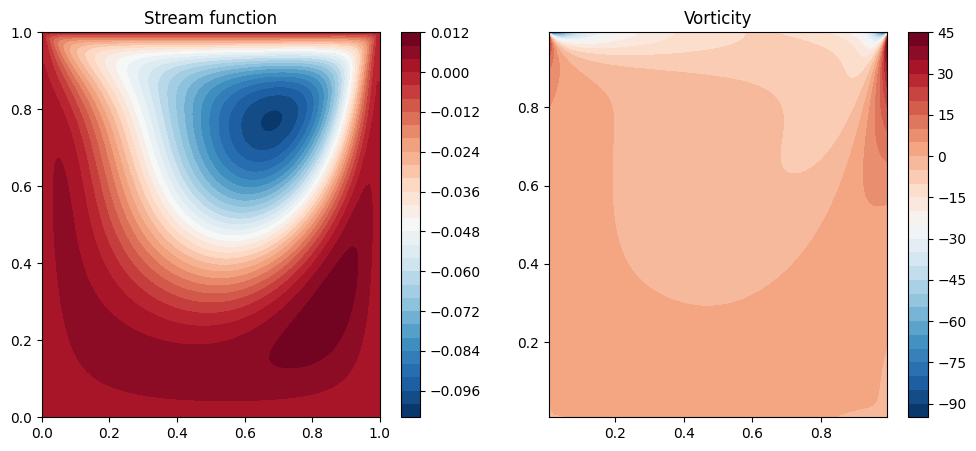

In [31]:
import matplotlib.pyplot as plt

data = np.load("/content/drive/MyDrive/cavity_flow_100_128.npz")
u, v, p = data["u"], data["v"], data["p"]

def cal_vorticity(u, v, h):
  omega = (v[1:-1, 2:-1] - v[1:-1, 1:-2])/h - (u[2:-1,1:-1] - u[1:-2, 1:-1])/h

  return omega #(n-1)x(n-1)

def cal_stream_func(rhs, h, tol = 1e-6, max_iter = 10000, omega = 1.7):
  n, m = rhs.shape
  psi = np.zeros((n+2,m+2)) #(n+1)x(n+1)

  for it in range(max_iter):
    psi_old = psi.copy()
    psi[1:-1,1:-1] = (1-omega)*psi[1:-1,1:-1] + omega*0.25*(
        psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2]
          - h**2 * rhs
    )
    # 경계조건 (예: cavity flow → 벽면 ψ=0)
    psi[0,:] = 0
    psi[-1,:] = 0
    psi[:,0] = 0
    psi[:,-1] = 0

    # 수렴 검사
    if np.linalg.norm(psi - psi_old, ord=np.inf) < tol:
        break

  return psi

vorticity = cal_vorticity(u, v, h = 1/128)
streamfunc = cal_stream_func(-vorticity, h = 1/128, tol = 1e-6, max_iter = 2000, omega = 1)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Stream function
cs1 = ax[0].contourf(X, Y, streamfunc, levels=30, cmap="RdBu_r")
ax[0].set_title("Stream function")
fig.colorbar(cs1, ax=ax[0])

# Vorticity (X,Y 잘라주기)
cs2 = ax[1].contourf(X[1:-1,1:-1], Y[1:-1,1:-1], vorticity, levels=30, cmap="RdBu_r")
ax[1].set_title("Vorticity")
fig.colorbar(cs2, ax=ax[1])

plt.show()


##(2) Re = 400

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 데이터 불러오기
data = np.load("/content/drive/MyDrive/cavity_flow_400_128.npz")
u = data['u']  # (n+2, n+1)
v = data['v']  # (n+1, n+2)
X = data['X']  # (n+1, n+1)
Y = data['Y']  # (n+1, n+1)

u_center = (u[1:-1, :-1] + u[1:-1, 1:]) / 2  # 크기: (n, n)
v_center = (v[:-1, 1:-1] + v[1:, 1:-1]) / 2  # 크기: (n, n)

X_center = (X[:-1, :-1] + X[1:, 1:]) / 2
Y_center = (Y[:-1, :-1] + Y[1:, 1:]) / 2

# Streamplot 그리기
plt.figure(figsize=(5, 5))
plt.streamplot(X_center, Y_center, u_center, v_center, density=2, linewidth=1, arrowsize=1.5)
plt.title('Streamplot of Cavity Flow(Re=1000)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 시뮬레이션 데이터 불러오기
data = np.load("/content/drive/MyDrive/cavity_flow_400_128.npz")
u, v, p = data["u"], data["v"], data["p"]

# 중심선 좌표 (128개, 내부 격자점)
centerline = np.linspace(1/129, 128/129, 128)

# 시뮬레이션 중심선 데이터
u_centerline = u[1:-1, 64]  # shape (128,)
v_centerline = v[64, 1:-1]  # shape (128,)

# u 비교 그래프 (y 축 방향)
plt.figure(figsize=(6,5))
plt.plot(centerline, u_centerline, 'b-', label='Simulation u (centerline)')
plt.scatter(y_vals, u_data[1000], c='r', marker='o', label='Reference u (Re=1000)')
plt.xlabel('y')
plt.ylabel('u velocity')
plt.title('Comparison of u velocity at centerline')
plt.legend()
plt.grid()

# v 비교 그래프 (x 축 방향)
plt.figure(figsize=(6,5))
plt.plot(centerline, v_centerline, 'b-', label='Simulation v (centerline)')
plt.scatter(x_vals, v_data[1000], c='r', marker='o', label='Reference v (Re=1000)')
plt.xlabel('x')
plt.ylabel('v velocity')
plt.title('Comparison of v velocity at centerline')
plt.legend()
plt.grid()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

data = np.load("/content/drive/MyDrive/cavity_flow_400_128.npz")
u, v, p = data["u"], data["v"], data["p"]

def cal_vorticity(u, v, h):
  omega = (v[1:-1, 2:-1] - v[1:-1, 1:-2])/h - (u[2:-1,1:-1] - u[1:-2, 1:-1])/h

  return omega #(n-1)x(n-1)

def cal_stream_func(rhs, h, tol = 1e-6, max_iter = 10000, omega = 1.7):
  n, m = rhs.shape
  psi = np.zeros((n+2,m+2)) #(n+1)x(n+1)

  for it in range(max_iter):
    psi_old = psi.copy()
    psi[1:-1,1:-1] = (1-omega)*psi[1:-1,1:-1] + omega*0.25*(
        psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2]
          - h**2 * rhs
    )
    # 경계조건 (예: cavity flow → 벽면 ψ=0)
    psi[0,:] = 0
    psi[-1,:] = 0
    psi[:,0] = 0
    psi[:,-1] = 0

    # 수렴 검사
    if np.linalg.norm(psi - psi_old, ord=np.inf) < tol:
        break

  return psi

vorticity = cal_vorticity(u, v, h = 1/128)
streamfunc = cal_stream_func(-vorticity, h = 1/128, tol = 1e-6, max_iter = 2000, omega = 1)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Stream function
cs1 = ax[0].contourf(X, Y, streamfunc, levels=30, cmap="RdBu_r")
ax[0].set_title("Stream function")
fig.colorbar(cs1, ax=ax[0])

# Vorticity (X,Y 잘라주기)
cs2 = ax[1].contourf(X[1:-1,1:-1], Y[1:-1,1:-1], vorticity, levels=30, cmap="RdBu_r")
ax[1].set_title("Vorticity")
fig.colorbar(cs2, ax=ax[1])

plt.show()


##(3) Re = 1000

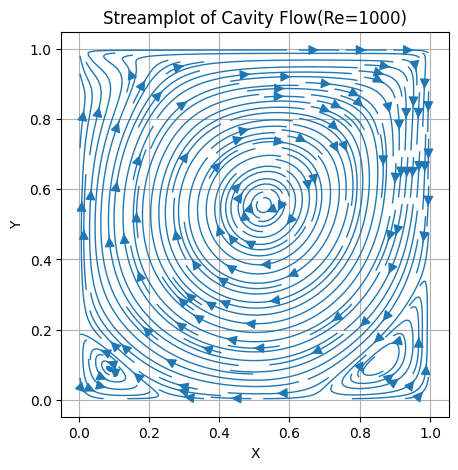

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 데이터 불러오기
data = np.load("/content/drive/MyDrive/cavity_flow_1000_128.npz")
u = data['u']  # (n+2, n+1)
v = data['v']  # (n+1, n+2)
X = data['X']  # (n+1, n+1)
Y = data['Y']  # (n+1, n+1)

u_center = (u[1:-1, :-1] + u[1:-1, 1:]) / 2  # 크기: (n, n)
v_center = (v[:-1, 1:-1] + v[1:, 1:-1]) / 2  # 크기: (n, n)

X_center = (X[:-1, :-1] + X[1:, 1:]) / 2
Y_center = (Y[:-1, :-1] + Y[1:, 1:]) / 2

# Streamplot 그리기
plt.figure(figsize=(5, 5))
plt.streamplot(X_center, Y_center, u_center, v_center, density=2, linewidth=1, arrowsize=1.5)
plt.title('Streamplot of Cavity Flow(Re=1000)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()


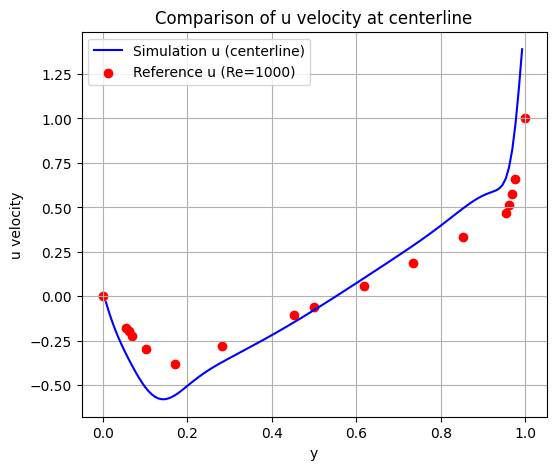

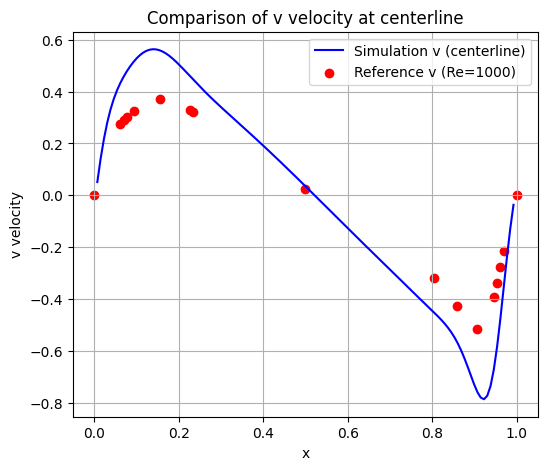

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 저장된 시뮬레이션 데이터 불러오기
data = np.load("/content/drive/MyDrive/cavity_flow_1000_128.npz")
u, v, p = data["u"], data["v"], data["p"]

# 중심선 좌표 (128개, 내부 격자점)
centerline = np.linspace(1/129, 128/129, 128)

# 시뮬레이션 중심선 데이터
u_centerline = u[1:-1, 64]  # shape (128,)
v_centerline = v[64, 1:-1]  # shape (128,)

# u 비교 그래프 (y 축 방향)
plt.figure(figsize=(6,5))
plt.plot(centerline, u_centerline, 'b-', label='Simulation u (centerline)')
plt.scatter(y_vals, u_data[1000], c='r', marker='o', label='Reference u (Re=1000)')
plt.xlabel('y')
plt.ylabel('u velocity')
plt.title('Comparison of u velocity at centerline')
plt.legend()
plt.grid()

# v 비교 그래프 (x 축 방향)
plt.figure(figsize=(6,5))
plt.plot(centerline, v_centerline, 'b-', label='Simulation v (centerline)')
plt.scatter(x_vals, v_data[1000], c='r', marker='o', label='Reference v (Re=1000)')
plt.xlabel('x')
plt.ylabel('v velocity')
plt.title('Comparison of v velocity at centerline')
plt.legend()
plt.grid()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

data = np.load("/content/drive/MyDrive/cavity_flow_1000_128.npz")
u, v, p = data["u"], data["v"], data["p"]

def cal_vorticity(u, v, h):
  omega = (v[1:-1, 2:-1] - v[1:-1, 1:-2])/h - (u[2:-1,1:-1] - u[1:-2, 1:-1])/h

  return omega #(n-1)x(n-1)

def cal_stream_func(rhs, h, tol = 1e-6, max_iter = 10000, omega = 1.7):
  n, m = rhs.shape
  psi = np.zeros((n+2,m+2)) #(n+1)x(n+1)

  for it in range(max_iter):
    psi_old = psi.copy()
    psi[1:-1,1:-1] = (1-omega)*psi[1:-1,1:-1] + omega*0.25*(
        psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2]
          - h**2 * rhs
    )
    # 경계조건 (예: cavity flow → 벽면 ψ=0)
    psi[0,:] = 0
    psi[-1,:] = 0
    psi[:,0] = 0
    psi[:,-1] = 0

    # 수렴 검사
    if np.linalg.norm(psi - psi_old, ord=np.inf) < tol:
        break

  return psi

vorticity = cal_vorticity(u, v, h = 1/128)
streamfunc = cal_stream_func(-vorticity, h = 1/128, tol = 1e-6, max_iter = 2000, omega = 1)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Stream function
cs1 = ax[0].contourf(X, Y, streamfunc, levels=30, cmap="RdBu_r")
ax[0].set_title("Stream function")
fig.colorbar(cs1, ax=ax[0])

# Vorticity (X,Y 잘라주기)
cs2 = ax[1].contourf(X[1:-1,1:-1], Y[1:-1,1:-1], vorticity, levels=30, cmap="RdBu_r")
ax[1].set_title("Vorticity")
fig.colorbar(cs2, ax=ax[1])

plt.show()
